##Superdream notebook

The code is shamelessy copied from https://github.com/jrosebr1/bat-country/, and adapted to be easy to use with IPython Notebooks.


This defines all the classes, functions and variables:

In [1]:
# import the necessary packages
from __future__ import print_function
from google.protobuf import text_format
from cStringIO import StringIO
from PIL import Image
import PIL.Image
from IPython.display import clear_output, Image, display
import scipy.ndimage as nd
import numpy as np
import caffe
import os
import random
import string
caffe.set_device(0)
caffe.set_mode_gpu()
layernames = 'data,conv1/7x7_s2,pool1/3x3_s2,pool1/norm1,conv2/3x3_reduce,conv2/3x3,conv2/norm2,pool2/3x3_s2,pool2/3x3_s2_pool2/3x3_s2_0_split_0,pool2/3x3_s2_pool2/3x3_s2_0_split_1,pool2/3x3_s2_pool2/3x3_s2_0_split_2,pool2/3x3_s2_pool2/3x3_s2_0_split_3,inception_3a/1x1,inception_3a/3x3_reduce,inception_3a/3x3,inception_3a/5x5_reduce,inception_3a/5x5,inception_3a/pool,inception_3a/pool_proj,inception_3a/output,inception_3a/output_inception_3a/output_0_split_0,inception_3a/output_inception_3a/output_0_split_1,inception_3a/output_inception_3a/output_0_split_2,inception_3a/output_inception_3a/output_0_split_3,inception_3b/1x1,inception_3b/3x3_reduce,inception_3b/3x3,inception_3b/5x5_reduce,inception_3b/5x5,inception_3b/pool,inception_3b/pool_proj,inception_3b/output,pool3/3x3_s2,pool3/3x3_s2_pool3/3x3_s2_0_split_0,pool3/3x3_s2_pool3/3x3_s2_0_split_1,pool3/3x3_s2_pool3/3x3_s2_0_split_2,pool3/3x3_s2_pool3/3x3_s2_0_split_3,inception_4a/1x1,inception_4a/3x3_reduce,inception_4a/3x3,inception_4a/5x5_reduce,inception_4a/5x5,inception_4a/pool,inception_4a/pool_proj,inception_4a/output,inception_4a/output_inception_4a/output_0_split_0,inception_4a/output_inception_4a/output_0_split_1,inception_4a/output_inception_4a/output_0_split_2,inception_4a/output_inception_4a/output_0_split_3,inception_4b/1x1,inception_4b/3x3_reduce,inception_4b/3x3,inception_4b/5x5_reduce,inception_4b/5x5,inception_4b/pool,inception_4b/pool_proj,inception_4b/output,inception_4b/output_inception_4b/output_0_split_0,inception_4b/output_inception_4b/output_0_split_1,inception_4b/output_inception_4b/output_0_split_2,inception_4b/output_inception_4b/output_0_split_3,inception_4c/1x1,inception_4c/3x3_reduce,inception_4c/3x3,inception_4c/5x5_reduce,inception_4c/5x5,inception_4c/pool,inception_4c/pool_proj,inception_4c/output,inception_4c/output_inception_4c/output_0_split_0,inception_4c/output_inception_4c/output_0_split_1,inception_4c/output_inception_4c/output_0_split_2,inception_4c/output_inception_4c/output_0_split_3,inception_4d/1x1,inception_4d/3x3_reduce,inception_4d/3x3,inception_4d/5x5_reduce,inception_4d/5x5,inception_4d/pool,inception_4d/pool_proj,inception_4d/output,inception_4d/output_inception_4d/output_0_split_0,inception_4d/output_inception_4d/output_0_split_1,inception_4d/output_inception_4d/output_0_split_2,inception_4d/output_inception_4d/output_0_split_3,inception_4e/1x1,inception_4e/3x3_reduce,inception_4e/3x3,inception_4e/5x5_reduce,inception_4e/5x5,inception_4e/pool,inception_4e/pool_proj,inception_4e/output,pool4/3x3_s2,pool4/3x3_s2_pool4/3x3_s2_0_split_0,pool4/3x3_s2_pool4/3x3_s2_0_split_1,pool4/3x3_s2_pool4/3x3_s2_0_split_2,pool4/3x3_s2_pool4/3x3_s2_0_split_3,inception_5a/1x1,inception_5a/3x3_reduce,inception_5a/3x3,inception_5a/5x5_reduce,inception_5a/5x5,inception_5a/pool,inception_5a/pool_proj,inception_5a/output,inception_5a/output_inception_5a/output_0_split_0,inception_5a/output_inception_5a/output_0_split_1,inception_5a/output_inception_5a/output_0_split_2,inception_5a/output_inception_5a/output_0_split_3,inception_5b/1x1,inception_5b/3x3_reduce,inception_5b/3x3,inception_5b/5x5_reduce,inception_5b/5x5,inception_5b/pool,inception_5b/pool_proj,inception_5b/output,pool5/7x7_s1,loss3/classifier,prob'
layernames = layernames.split(",")
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

class BatCountry:
	def __init__(self, base_path, deploy_path=None, model_path=None,
		patch_model="./tmp.prototxt", mean=(104.0, 116.0, 122.0),
		channels=(2, 1, 0)):
		# if the deploy path is None, set the default
		if deploy_path is None:
			deploy_path = base_path + "/deploy.prototxt"

		# if the model path is None, set it to the default GoogleLeNet model
		if model_path is None:
			model_path = base_path + "/bvlc_googlenet.caffemodel"

		# check to see if the model should be patched to compute gradients
		if patch_model:
			model = caffe.io.caffe_pb2.NetParameter()
			text_format.Merge(open(deploy_path).read(), model)
			model.force_backward = True
			f = open(patch_model, "w")
			f.write(str(model))
			f.close()

		# load the network and store the patched model path
		self.net = caffe.Classifier(patch_model, model_path, mean=np.float32(mean),
			channel_swap=channels)
		self.patch_model = patch_model

	def dream(self, image, iter_n=10, octave_n=4, octave_scale=1.4,
		end="inception_4c/output", clip=True, step_fn=None, objective_fn=None,
		preprocess_fn=None, deprocess_fn=None, verbose=True, visualize=True,
		**step_params):
		# if a step function has not been supplied, initialize it as the
		# standard gradient ascent step
		if step_fn is None:
			step_fn = BatCountry.gradient_ascent_step

		# if the objective function has not been supplied, initialize it
		# as the L2 objective
		if objective_fn is None:
			objective_fn = BatCountry.L2_objective

		# if the preprocess function has not been supplied, initialize it
		if preprocess_fn is None:
			preprocess_fn = BatCountry.preprocess

		# if the deprocess function has not been supplied, initialize it
		if deprocess_fn is None:
			deprocess_fn = BatCountry.deprocess

		# initialize the visualization list
		visualizations = []

		# prepare base images for all octaves
		octaves = [preprocess_fn(self.net, image)]

		for i in xrange(octave_n - 1):
			octaves.append(nd.zoom(octaves[-1], (1, 1.0 / octave_scale,
				1.0 / octave_scale), order=1))

		# allocate image for network-produced details
		detail = np.zeros_like(octaves[-1])
		src = self.net.blobs["data"]

		for octave, octave_base in enumerate(octaves[::-1]):
			h, w = octave_base.shape[-2:]

			if octave > 0:
				# upscale details from the previous octave
				h1, w1 = detail.shape[-2:]
				detail = nd.zoom(detail, (1, 1.0 * h/ h1, 1.0 * w / w1), order=1)

 			# resize the network's input image size
			src.reshape(1, 3, h, w)
			src.data[0] = octave_base + detail

			for i in xrange(iter_n):
				step_fn(self.net, end=end, clip=clip, objective_fn=objective_fn,
					**step_params)

				# visualization
				vis = deprocess_fn(self.net, src.data[0])
				showarray(vis)
				# adjust image contrast if clipping is disabled
				if not clip: 
					vis = vis * (255.0 / np.percentile(vis, 99.98))

				if verbose:
					print("octave={}, iter={}, layer={}, image_dim={}".format(octave, i, end, vis.shape))
					clear_output(wait=True)
                    
				# check to see if the visualization list should be
				# updated
				if visualize:
					k = "octave_{}-iter_{}-layer_{}".format(octave, i,
						end.replace("/", "_"))
					visualizations.append((k, vis))

			# extract details produced on the current octave
			detail = src.data[0] - octave_base

		# grab the resulting image
		r = deprocess_fn(self.net, src.data[0])

		# check to see if the visualizations should be included
		if visualize:
			r = (r, visualizations)

		return r

	@staticmethod
	def gradient_ascent_step(net, step_size=1.5, end="inception_4c/output",
		jitter=128, clip=True, objective_fn=None, **objective_params):
		# if the objective function is None, initialize it as
		# the standard L2 objective
		if objective_fn is None:
			objective_fn = BatCountry.L2_objective

		# input image is stored in Net's 'data' blob
		src = net.blobs["data"]
		dst = net.blobs[end]

		# apply jitter shift
		ox, oy = np.random.randint(-jitter, jitter + 1, 2)
		src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2)

		net.forward(end=end)
		objective_fn(dst, **objective_params)
		net.backward(start=end)
		g = src.diff[0]

		# apply normalized ascent step to the input image
		src.data[:] += step_size / np.abs(g).mean() * g

 		# unshift image
		src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2)

		# unshift image
		if clip:
			bias = net.transformer.mean["data"]
			src.data[:] = np.clip(src.data, -bias, 255 - bias)

	def layers(self):
		# return the layers of the network
		return self.net._layer_names

	def cleanup(self):
		# remove the patched model from disk
		os.remove(self.patch_model)

	def prepare_guide(self, image, end="inception_4c/output", maxW=224, maxH=224,
		preprocess_fn=None):
		# if the preprocess function has not been supplied, initialize it
		if preprocess_fn is None:
			preprocess_fn = BatCountry.preprocess

		# grab dimensions of input image
		(w, h) = image.size

		# GoogLeNet was trained on images with maximum width and heights
		# of 224 pixels -- if either dimension is larger than 224 pixels,
		# then we'll need to do some resizing
		if h > maxH or w > maxW:
			# resize based on width
			if w > h:
				r = maxW / float(w)

			# resize based on height
			else:
				r = maxH / float(h)

			# resize the image
			(nW, nH) = (int(r * w), int(r * h))
			image = np.float32(image.resize((nW, nH), PIL.Image.BILINEAR))

		(src, dst) = (self.net.blobs["data"], self.net.blobs[end])
		src.reshape(1, 3, nH, nW)
		src.data[0] = preprocess_fn(self.net, image)
		self.net.forward(end=end)
		guide_features = dst.data[0].copy()

		return guide_features

	@staticmethod
	def L2_objective(dst):
		dst.diff[:] = dst.data

	@staticmethod
	def guided_objective(dst, objective_features):
		x = dst.data[0].copy()
		y = objective_features
		ch = x.shape[0]
		x = x.reshape(ch,-1)
		y = y.reshape(ch,-1)

		# compute the matrix of dot-products with guide features
		A = x.T.dot(y) 

		# select ones that match best
		dst.diff[0].reshape(ch, -1)[:] = y[:,A.argmax(1)]

	@staticmethod
	def preprocess(net, img):
		return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean["data"]

	@staticmethod
	def deprocess(net, img):
		return np.dstack((img + net.transformer.mean["data"])[::-1])

Here we define the model files.
They are not included, so you need to download them. A quick search for the file names should point you in the right direction.

Run just one of them.

In [2]:
model_path = '/Users/spiorf/Desktop/deepdream/models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

In [2]:
model_path = '/Users/spiorf/Desktop/deepdream/models/googlenet_places205/' # substitute your path here
net_fn   = model_path + 'deploy_places205.protxt'
param_fn = model_path + 'googlelet_places205_train_iter_2400000.caffemodel'

Here you can begin to play changing the images or the other parameters.

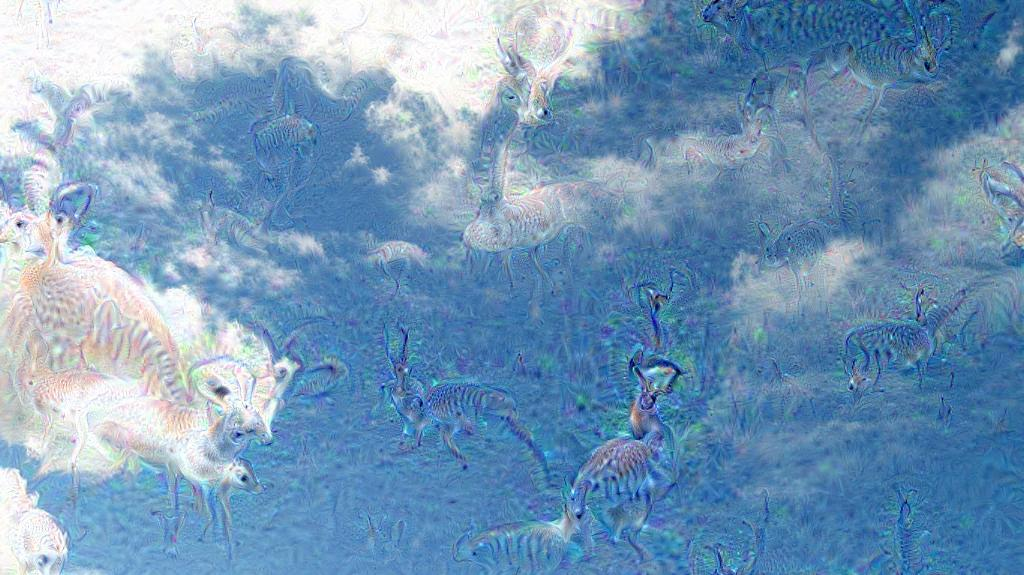

In [8]:
rootdir = '/Users/spiorf/Desktop/dreams/'
name_prefix = '_out_'

bc = BatCountry(model_path,deploy_path=net_fn, model_path=param_fn)
end=layernames[105]

img = np.float32(PIL.Image.open('/Users/spiorf/Desktop/deepdream/source_images/clouds.jpg'))
features = bc.prepare_guide(PIL.Image.open('/Users/spiorf/Desktop/deepdream/guide_images/antelope.jpg'), end=end)

#image = bc.dream(img, iter_n=20, octave_n=4, octave_scale=1.3, end=end, verbose=True, visualize=False)
image = bc.dream(img, iter_n=10, octave_n=4, octave_scale=1.5, end=end, objective_fn=BatCountry.guided_objective, 
                 objective_features=features, verbose=True, visualize=False)
bc.cleanup()
showarray(image)
filename = ''.join(random.SystemRandom().choice(string.ascii_uppercase + string.digits) for _ in range(10))
PIL.Image.fromarray(np.uint8(image)).save(rootdir + name_prefix + "%s.jpg"%filename)

With this cell we scan a folder and process every file.

In [ ]:
rootdir = 'C:/Users/spiorf/Desktop/todream'
name_prefix = '_out_'
bc = BatCountry(model_path,deploy_path=net_fn, model_path=param_fn)
end=layernames[80]

features = bc.prepare_guide(PIL.Image.open('/Users/spiorf/Desktop/deepdream/guide_images/spider.jpg'), end=end)

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        print(os.path.join(subdir, file))
        img = np.float32(PIL.Image.open(os.path.join(subdir, file)))
        _=image = bc.dream(img, iter_n=10, octave_n=4, octave_scale=1.3, end=end, objective_fn=BatCountry.guided_objective, objective_features=features, verbose=True, visualize=False)
        showarray(_)
        fileout = name_prefix + file 
        PIL.Image.fromarray(np.uint8(_)).save(os.path.join(subdir, fileout))

This cell generates a file for every layer from the same starting image.

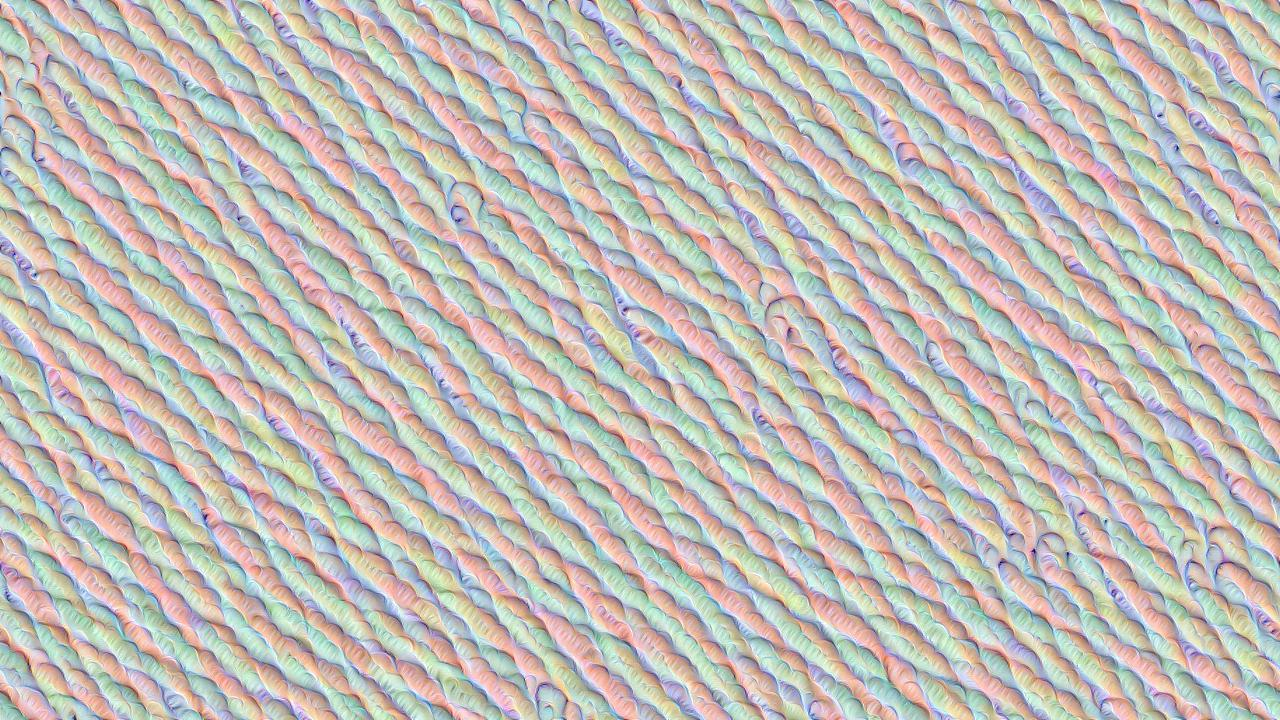

octave=3, iter=16, layer=inception_3a/3x3_reduce, image_dim=(720L, 1280L, 3L)


In [ ]:
#Output dir
rootdir = '/Users/spiorf/Desktop/dreams/'
name_prefix = 'antelopelayer-'

if not os.path.exists(rootdir):
    os.makedirs(rootdir)
    #Start image    
startimage = '/Users/spiorf/Desktop/deepdream/source_images/wall720.jpg'


    #Guide image
guideimage = '/Users/spiorf/Desktop/deepdream/guide_images/antelope.jpg'


#Init model
bc = BatCountry(model_path,deploy_path=net_fn, model_path=param_fn)


i=10

while i< (len(layernames)):
    try:
            features = bc.prepare_guide(PIL.Image.open(guideimage), end=layernames[i])
            img = np.float32(PIL.Image.open(startimage))
#            frame = bc.dream(img, iter_n=20, octave_n=4, octave_scale=1.3, end=layernames[i], verbose=True, visualize=False) # Uncomment for unguided image
            frame = bc.dream(img, iter_n=50, octave_n=4, octave_scale=1.4, end=layernames[i],         #
                             objective_fn=BatCountry.guided_objective, objective_features=features,   # Comment for unguided image
                             verbose=True, visualize=False)                                           #
            filename = name_prefix + `i` + "-" + layernames[i].replace('/', '')
            PIL.Image.fromarray(np.uint8(frame)).save(rootdir + "%s.jpg"%filename)
            print(i+1, str(layernames[i]))
            i +=1
    except ValueError:
        print('Skipped', i, str(layernames[i]))
        i +=1
        pass
    except KeyError:
        print('Skipped', i, str(layernames[i]))
        i +=1
        pass
bc.cleanup()

This cell generates a video (in the form of a serie of jpgs) zooming a bit and reprocessing the image.

In [6]:
#Output dir
rootdir = '/Users/spiorf/Desktop/dreams/'
name_prefix = 'video'

if not os.path.exists(rootdir):
    os.makedirs(rootdir)
    

#Start image    
startimage = '/Users/spiorf/Desktop/deepdream/source_images/noise3.jpg'


#Guide image
guideimage = '/Users/spiorf/Desktop/deepdream/guide_images/pines.jpg'

#Zoom
s = 0.05

end=layernames[80]


#Init model
bc = BatCountry(model_path,deploy_path=net_fn, model_path=param_fn)
img = np.float32(PIL.Image.open(startimage))
features = bc.prepare_guide(PIL.Image.open(guideimage), end=end)
if not os.path.exists(rootdir):
    os.makedirs(rootdir)
i=1 


frame = img
h, w = frame.shape[:2]
while i< 10000:
    try:

#            frame = bc.dream(img, iter_n=20, octave_n=4, octave_scale=1.3, end=layernames[i], verbose=True, visualize=False) # Uncomment for unguided image
            frame = bc.dream(frame, iter_n=20, octave_n=4, octave_scale=1.4, end=end,                  #
                             objective_fn=BatCountry.guided_objective, objective_features=features,   # Comment for unguided image
                             verbose=True, visualize=False)                                           #
            filename = name_prefix + `i` + "-" + layernames[i].replace('/', '')
            PIL.Image.fromarray(np.uint8(frame)).save(rootdir + name_prefix + "%07d.jpg"%i)
            frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
            print(i, str(layernames[i]))
            i +=1
    except ValueError:
        print('Skipped', i, str(layernames[i]))
        i +=1
        pass
    except KeyError:
        print('Skipped', i, str(layernames[i]))
        i +=1
        pass

bc.cleanup()


KeyboardInterrupt: 